### Análisis de ECG con TDA para detección de enfermedades cardíacas
####Por: Sergio Alejandro Esparza González.
####Última modificación: 1 de mayo de 2025.

Los problemas del corazón son una de las principales causas de muerte en el mundo y México es una de las naciones con mayor índice de enfermedades cardíacas. La detección temprana de enfermedades cardíacas es crucial para prevenir complicaciones graves y mejorar la calidad de vida de los pacientes. En este contexto, es importante analizar los factores que pueden contribuir a la aparición de enfermedades cardíacas y desarrollar modelos predictivos que ayuden a identificar a las personas en riesgo. Las lecturas de electrocardiogramas (ECG) son una herramienta valiosa para el diagnóstico de enfermedades cardíacas, ya que permiten evaluar la actividad eléctrica del corazón y detectar anomalías en su funcionamiento (los valores de voltaje en el tiempo del músculo cardíaco, medidos con electrodos en la piel). Sin embargo, la interpretación de los ECG puede ser compleja y requiere experiencia médica. Por lo tanto, es importante desarrollar modelos de aprendizaje automático que puedan analizar los ECG y ayudar a los médicos a tomar decisiones informadas sobre el diagnóstico y tratamiento de enfermedades cardíacas. Se utilizará un algoritmo de Uso de Geometría y Topología para la Ciencia de Datos para analizar los ECG. Además de la base de datos:

https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data


### Preguntas de investigación:

1. ¿Existen diferencias topológicas claras entre latidos nor-
males y latidos anormales en señnales ECG?

2. ¿Los vectores de características basados en TDA, por
ejemplo, los Persistence Landscapes permiten clasificar
latidos normales vs. anormales con una alta precisión?

## Objetivo

Desarrollar y evaluar un sistema de clasificación binaria
de latidos normales y anormales, aprovechando los descrip-
tores topológicos derivados de la homología persistente, tal
como los Persistence Landscapes, obtenidos a partir de la
incrustación de ventana deslizante de la señal ECG, para posteriormente realizar su clasificación utilizando algoritmos de aprendizaje automático, como Random Forest.

#### Carga y construcción de datos

In [ ]:
# Instalaciones:
!pip install gudhi -q # Persistencia.
!pip install ripser -q # Vietoris-Rips.
!pip install tqdm -q # Barras de progreso.
!pip install -U nolds -q # Análisis de series temporales no lineales.

In [ ]:
# Importaciones:
import kagglehub # Datasets de Kaggle.
import os # Sistema operativo.
import pandas as pd # Análisis de datos.
import numpy as np # Arreglos multidimensionales.
from numpy.linalg import svd # Descomposición en valores singulares.
import matplotlib.pyplot as plt # Gráficas.
import seaborn as sns # Gráficas estilizadas.
# Dividir datos en conjuntos de entrenamiento y prueba:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # Bosque aleatorio.
# Rendimiento del modelo:
from sklearn.metrics import classification_report, roc_auc_score
# Búsqueda exhaustiva de hiperparámetros:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix # Matriz de confusión.
from gudhi.representations import Landscape # Paisajes de persistencia.
from ripser import ripser # Vietoris-Rips
from imblearn.combine import SMOTEENN # Balancear clases.
from collections import Counter # Contar registros por clase.
from tqdm import tqdm # Barra de progreso.
from tqdm.auto import tqdm # Barra de progreso adaptativa.
from pyinform import mutual_info # Información mutua entre dos señales.
import nolds # Funciones de dinámica no lineal.

In [ ]:
# Descargar archivos en la ruta de Kaggle:
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

# Ver archivos que tenía la ruta:
print("Contenido de la carpeta:", os.listdir(path))

Contenido de la carpeta: ['ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_test.csv', 'mitbih_train.csv']


In [ ]:
# Cargar los CSVs como DataFrames de Pandas sin encabezado, seleccionando el
  # archivo específico de la ruta para trabajar:
df_ptbdb_abnormal = pd.read_csv(os.path.join(path, 'ptbdb_abnormal.csv'),
                                header=None) # Latidos anormales.
df_ptbdb_normal = pd.read_csv(os.path.join(path, 'ptbdb_normal.csv'),
                              header=None) # Latidos normales.

In [ ]:
df_ptbdb_normal.head() # Mostrar los primeros 5 registros.

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_ptbdb_normal.shape # Mostrar dimensiones.

(4046, 188)

Se divide en 4046 registros, que corresponden a 4046 latidos normales, y se divide en 188 columnas, de las cuales son 187 mediciones del voltaje del latido, y la última columna es el tipo de latido, en este caso todos los valores son 0 porque así se denotan los latidos normales.

In [ ]:
df_ptbdb_abnormal.head() # Mostrar los primeros 5 registros.

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_ptbdb_abnormal.shape # Mostrar dimensiones.

(10506, 188)

Se divide en 10506 registros, que corresponden a 10506 latidos anormales, y se divide en 188 columnas, de las cuales son 187 mediciones del voltaje del latido, y la última columna es el tipo de latido, en este caso todos los valores son 1 porque así se denotan los latidos anormales.

### Limpieza y análisis estadístico

In [ ]:
# Datos nulos:
print("Cantidad de datos nulos en el DataFrame de los latidos normales:",
      df_ptbdb_normal.isnull().sum().sum())
print("Cantidad de datos nulos en el DataFrame de los latidos anormales:",
      df_ptbdb_abnormal.isnull().sum().sum())

Cantidad de datos nulos en el DataFrame de los latidos normales: 0
Cantidad de datos nulos en el DataFrame de los latidos anormales: 0


Al no tener datos nulos, no se requiere preprocesamiento en este aspecto (interpolación, KNN, regresión, MICE, etc.)

In [ ]:
# Filas duplicadas:
print("Cantidad de filas duplicadas en el DataFrame de los latidos normales:",
      df_ptbdb_normal.duplicated().sum())
print("Cantidad de filas duplicadas en el DataFrame de los latidos anormales:",
      df_ptbdb_abnormal.duplicated().sum())

Cantidad de filas duplicadas en el DataFrame de los latidos normales: 1
Cantidad de filas duplicadas en el DataFrame de los latidos anormales: 6


Al tener registros duplicados en los datasets, se requieren eliminar, pues son redundantes para el análisis.

In [ ]:
# Eliminar filas duplicadas, con nuevos índices:
df_ptbdb_normal = df_ptbdb_normal.drop_duplicates().reset_index(drop=True)
df_ptbdb_abnormal = df_ptbdb_abnormal.drop_duplicates().reset_index(drop=True)

# Confirmar que ya no hay filas duplicadas:
print("Cantidad de filas duplicadas en el DataFrame de los latidos normales:",
      df_ptbdb_normal.duplicated().sum())
print("Cantidad de filas duplicadas en el DataFrame de los latidos anormales:",
      df_ptbdb_abnormal.duplicated().sum())

Cantidad de filas duplicadas en el DataFrame de los latidos normales: 0
Cantidad de filas duplicadas en el DataFrame de los latidos anormales: 0


In [ ]:
df_ptbdb_normal.shape # Mostrar dimensiones.

(4045, 188)

In [ ]:
df_ptbdb_abnormal.shape # Mostrar dimensiones.

(10500, 188)

Ahora solo se tienen 4045 registros de latidos normales y 10500 de latidos anormales.

In [ ]:
# Unir los DataFrames de manera vertical, registros normales arriba y anormales
  # abajo, con nuevos índices:
df_ptbdb = pd.concat([df_ptbdb_normal, df_ptbdb_abnormal], ignore_index=True)

In [ ]:
df_ptbdb.shape # Mostrar dimensiones.

(14545, 188)

Ahora son 14545 registros de latidos totales.

In [ ]:
# Dividir en variables predictoras y objetivo:

# Variables predictoras (mediciones de voltaje), convertir a tipo flotante:
X = df_ptbdb.iloc[:, :-1].astype('float64')

# Variable objetivo (etiquetas de clase), convertir a enteros:
y = df_ptbdb.iloc[:, -1].astype('int')

In [ ]:
X.shape # Mostrar dimensiones.

(14545, 187)

In [ ]:
y.shape # Mostrar dimensiones.

(14545,)

Con esto, son 187 columnas para X porque cada una actúa como variable predictora, al ser las mediciones de voltaje de los latidos. Y una sola columna para y, pues actúa como única variable objetivo.

In [ ]:
# Dividir variables en conjunto de entrenamiento y de pruebas:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # Variables predictoras y objetivo.
    test_size=0.20, # Tamaño de la prueba (20%).
    stratify=y, # Estratificar, asegurando que se mantenga la proporción de
      # clases en entrenamiento y pruebas.
    random_state=69 # Fijar semilla aleatoria para reproductibilidad.
)

Ahora se separan los datos en conjuntos de entrenamiento y de prueba, de manera estratificada, para que la proporción de cada clase se mantenga en ambos subconjuntos y evaluar el rendimiento de manera equitativa y representativa.

In [ ]:
X_train.shape # Mostrar dimensiones.

(11636, 187)

In [ ]:
y_train.shape # Mostrar dimensiones.

(11636,)

Los conjuntos de entrenamiento, tanto de las variables predictoras, como de la variable objetivo tienen 11636 registros, correspondientes al 80% de registros totales que había originalmente.

In [ ]:
X_test.shape # Mostrar dimensiones.

(2909, 187)

In [ ]:
y_test.shape # Mostrar dimensiones.

(2909,)

Los conjuntos de prueba, tanto de las variables predictoras, como de la variable objetivo tienen 2909 registros, correspondientes al 20% de registros totales que había originalmente.

In [ ]:
X_train.describe() # Estadística descriptiva.

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
count,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,...,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.000000,11636.0
mean,0.976837,0.722277,0.403841,0.243451,0.207810,0.217427,0.222996,0.225394,0.227894,0.230323,...,0.001507,0.001213,0.001136,0.000844,0.000715,0.000628,0.000459,0.000132,0.000139,0.0
std,0.034247,0.195842,0.249633,0.249168,0.218607,0.193247,0.181588,0.177272,0.177054,0.176952,...,0.023490,0.022312,0.021890,0.017263,0.014947,0.014106,0.012601,0.005519,0.005795,0.0
min,0.624227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.959775,0.585281,0.213480,0.053006,0.061187,0.090650,0.096620,0.097437,0.097497,0.097463,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.741666,0.373900,0.169251,0.136295,0.160256,0.168275,0.172771,0.177793,0.180723,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.882303,0.560487,0.336812,0.265677,0.265534,0.287668,0.303247,0.312046,0.325513,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985523,0.993213,0.997738,...,0.746508,0.791899,0.773743,0.789804,0.628177,0.602033,0.644880,0.333903,0.350150,0.0


Se puede observar que en varias columnas, el valor mínimo es 0 y el valor máximo 1, indicando que probablemente se realizó previamente un escalamiento min-max en el intervalo [0,1]. De igual forma, al final hay columnas en donde la mayoría de los datos son 0, indicando asimetría positiva por los pocos outliers que no sean dicho valor. Entre más al centro estén las columnas, tienen valores más distribuidos con media alejada de 0 y desviación estándar mayor, pues se va llegando a la zona pico del ECG, en donde se da la mayor actividad ventricular.

In [ ]:
X_test.describe() # Estadística descriptiva.

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
count,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,...,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.000000,2909.0
mean,0.975919,0.718678,0.399612,0.240181,0.204387,0.212292,0.216585,0.220725,0.225070,0.227138,...,0.001102,0.001097,0.001125,0.001124,0.000838,0.000794,0.000539,0.000356,0.000372,0.0
std,0.035452,0.194987,0.250301,0.250644,0.215643,0.188803,0.177157,0.175559,0.175124,0.175058,...,0.017105,0.017071,0.017088,0.017547,0.013365,0.013755,0.010971,0.009614,0.009968,0.0
min,0.682243,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.957891,0.580383,0.207062,0.049107,0.065012,0.089502,0.095741,0.095907,0.096193,0.096250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.998996,0.733504,0.366370,0.164502,0.133911,0.157974,0.163527,0.166667,0.174947,0.177050,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.000000,0.877447,0.551869,0.330697,0.252174,0.257994,0.279389,0.295232,0.309141,0.321637,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.957099,0.959438,0.918877,0.921280,...,0.619523,0.611758,0.591237,0.602329,0.419150,0.444180,0.355575,0.371502,0.376668,0.0


La distribución de valores del conjunto de prueba es coherente con la del conjunto de entrenamiento, pues se pueden enunciar las mismas observaciones.

In [ ]:
y_train.describe() # Estadística descriptiva.

,187
count,11636.000000
mean,0.721898
std,0.448083
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


En la variable objetivo, al tener un mínimo de 0 y un máximo de 1 sin valores medios, se trata de un problema de clasificación binaria, al tener una media de 0.72, aproximadamente el 72% de los latidos son anormales, indicando un ligero desbalance.

In [ ]:
y_test.describe() # Estadística descriptiva.

,187
count,2909.000000
mean,0.721898
std,0.448141
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


En el conjunto de prueba, al tener el mismo porcentaje de latidos anormales que en el conjunto de entrenamiento, se confirma que la estratificación funcionó de manera correcta.

In [ ]:
# Balancear los datos del conjunto de entrenamiento usando SMOTE y ENN:
smote_enn = SMOTEENN(random_state=69) # Crear instancia del método, con semilla
  # fija.

# Aplicar método al conjunto de entrenamiento:
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train, y_train)

# Verificar el nuevo conteo de clases:
print("Distribución original:", Counter(y_train))
print("Distribución balanceada:", Counter(y_train_bal))

Distribución original: Counter({1: 8400, 0: 3236})
Distribución balanceada: Counter({0: 8169, 1: 7217})


Se balancearon las clases del conjunto de entrenamiento con SMOTEENN, que combina SMOTE (sobremuestreo), generando ejemplos sintéticos de la clase minoritaria y ENN (submuestreo), eliminando las instancias ruidosas. Así para mejorar la diversidad geométrica y topológica de cada clase, permitiendo que el TDA capture estructuras más representativas de ambas clases, haciendo que el clasificador no tenga sesgo. Ahora se tienen 8169 latidos anormales y 7217 normales, siendo una distribución más cercana al 50/50.

In [ ]:
# Convertir DataFrames en arreglos numéricos de Numpy para los métodos de
  # aprendizaje automático:
X_train_ = X_train_bal.values # Predictoras de entrenamiento.
y_train_ = y_train_bal.values # Objetivo de entrenamiento.
X_test_ = X_test.values # Predictoras de prueba.
y_test_ = y_test.values # Objetivo de prueba.

En este caso no fue necesario recurrir a técnicas multivariadas, como pruebas de normalidad multivariante, análisis factorial de variables latentes o correlación múltiple, pues el objetivo solo es obtener señales limpias y homogéneas para utilizar TDA.

### TDA y construcciones

Primero se aplicará un Sliding Window Embedding para mapear la serie de tiempo a R^n, buscando que n sea mayor que 1. El vector unidimensional de N elementos, se transforma en un vector de forma: ( N-(dim-1)\*tau ) x dim, donde cada fila i es el vector x(i), x(i+tau), x(i+2\*tau), ..., x(i+(dim-1)\*tau)).

In [ ]:
# Obtener el valor de retardo τ óptimo mediante una serie signal y un tope
  # máximo del valor max_lag:
def opt_tau_ami(signal, max_lag=40):

    # Para cada retardo posible k, calcular la información mutua entre la serie
      # truncada y su versión desplazada, dando la curva AMI:
    ami = [mutual_info(signal[:-k], signal[k:]) for k in range(1, max_lag)]

    # Devolver el retardo, siendo el primer mínimo de la AMI:
    return int(np.argmin(ami) + 1)

# Obtener el valor de la dimensión óptima mediante una serie signal, el valor de
  # retardo tau, un tope máximo del valor max_dim, y un umbral th:
def opt_dim_svd(signal, tau, max_dim=8, th=0.05):

    # Recorrer las dimensiones posibles:
    for m in range(2, max_dim+1):

        # Construir la matriz de Takens, donde cada columna es la señal retrasada:
        emb = np.column_stack([signal[i:len(signal)-(m-1-i)*tau:tau] for i in range(m)])

        # Devolver los valores singulares:
        s = svd(emb, compute_uv=False)

        # Si se genera una división por 0, se retorna 2:
        if s[0] == 0: return 2

        # Si el último singular entre el primero es menor al umbral, se asume
          # que las dimensiones adicionales solo añaden ruido, se retorna m:
        if s[m-1] / s[0] < th: return m
    return max_dim # Si no se satisface la condición, se devuelva la máxima.


Se obtiene el valor óptimo de tau al usar AMI, es decir, la información mutua (dependencia) promedio entre la señal x(t) y esa misma señal retardada x(t+tau), se obtiene aquella tau que maximice la independencia, seleccionando su primer mínimo.

Se obtiene el valor óptimo de dim al usar SVD, es decir, obtener el vector de los valores singulares de la matriz obtenida por sliding window embedding, de modo que al obtener su magnitud se obtiene la información explicada por cada componente, para elegir así la dimensión dim que retiene mayor parte de la información.

In [ ]:
latido_calib = X_train_[0] # Seleccionar el primer latido para encontrar los
  # parámetros óptimos.

In [ ]:
tau_opt = opt_tau_ami(latido_calib, max_lag=40) # Retardo óptimo.
dim_opt = opt_dim_svd(latido_calib, tau=tau_opt, max_dim=8) # Dimensión óptima.
print("τ opt=", tau_opt, ", dim opt=", dim_opt)

τ opt= 1 , dim opt= 4


En este caso, se obtuvo un retardo tau de 1 y una dimensión dim de 4.

In [ ]:
# Aplicar Sliding Window Embedding en una señal (signal) 1D, para poder mapearla
  # a una dimensión dim, de manera que conserve sus propiedades topológicas, con
  # tau pasos entre coordenadas:
def sliding_window_embedding(signal, dim, tau):

    N = len(signal) # Número de puntos en la señal.

    # Recorrer la señal, tomando una subsecuencia de longitud dim con separación
      # tau entre elementos. Se tendrán N - (dim-1) * tau puntos para evitar
      # desbordes en los índices:
    return np.array([signal[i:i+dim*tau:tau] for i in range(N - (dim-1)*tau)])
      # Se regresa así la nube de (N - (dim-1)*tau, dim) puntos en R^dim.

In [ ]:
# Trazar un arreglo 2D (embedding) con sus respectivas etiquetas (label), y un
  # título predefinido:
def plot_2d_embedding(embedding, label, title_prefix='Latido embebido'):
    plt.figure(figsize=(6, 5)) # Figura nueva de cierto tamaño.

    # Trazar la curva con puntos embebidos en R^2, con ancho lw y nivel de
      # transparencia alpha:
    plt.plot(embedding[:, 0], embedding[:, 1], lw=1.2, alpha=0.85)

    # Título con la clase del latido:
    plt.title(f'{title_prefix}: clase {label}')

    plt.xlabel('X₁') # Eje x.
    plt.ylabel('X₂') # Eje y.

    # Activar cuadrícula, con estilo de línea ls y nivel de transparencia alpha:
    plt.grid(True, ls='--', alpha=0.3)

    plt.show() # Mostrar figura.

In [ ]:
# Aplicar Sliding Window Embedding al conjunto de entrenamiento:
X_train_embedded = [sliding_window_embedding(latido,
  dim=dim_opt, tau=tau_opt) for latido in X_train_]

In [ ]:
# Si la dimensión óptima es 2:
if dim_opt == 2:
  # Graficar algunos ejemplos:
  plot_count_0 = 0 # Contador para clase 0.
  plot_count_1 = 0 # Contador para clase 1.

  # Recorrer todos los latidos embebidos:
  for i in range(len(X_train_embedded)):
      label = y_train_[i] # Etiqueta del latido.

      # Si es clase 0 y van menos de 5 graficados:
      if label == 0 and plot_count_0 < 5:

          # Graficar el embebido de clase 0:
          plot_2d_embedding(X_train_embedded[i], label,
                            title_prefix="Latido clase 0")
          plot_count_0 += 1 # Aumentar contador de clase 0.

      # Si es clase 1 y van menos de 5 graficados:
      elif label == 1 and plot_count_1 < 5:

          # Graficar el embebido de clase 0:
          plot_2d_embedding(X_train_embedded[i], label,
                            title_prefix="Latido clase 1")
          plot_count_1 += 1 # Aumentar contador de clase 1.

      # Si ya se graficaron 5 de cada clase:
      if plot_count_0 == 5 and plot_count_1 == 5:

          break # Salir del ciclo.

Nota: Esto pasa cuando la dimensión óptima es 2:
Se pueden observar diferencias cualitativas claras entre las trayectorias de los latidos normales (clase 0) y los anormales (clase 1). En los latidos de clase 0, las curvas son más regulares y cerradas, con trayectorias más "predecibles" que los latidos de clase 1, donde se observa mayor dispersión y trayectorias más caóticas, es probable que los latidos de clase 1 tengan más ciclos significativos, lo cual puede aprovecharse por el modelo.

Se calculan después los diagramas de persistencia, donde se puede representar de manera gráfica los nacimientos y muertes de las características topológicas a lo largo del filtrado del espacio dado por el cambio de un radio épsilon. En este caso, se hace una filtración de Vietoris-Rips, uniendo con un símplice a cada subconjunto de puntos cuya distancia mutua sea menor a épsilon.


In [ ]:
# 1-agujeros como máximo. De mayor dimensión se vuelve muy lento el programa:
md = 1

Probablemente si se consideraran 2-agujeros, se dieran mejores resultados.

In [ ]:
# Diagramas de persistencia:
dgms = [] # Lista para guardar los diagramas.

# Recorrer cada latido embebido, con una barra de progreso que indique cuántos
  # se han recorrido:
for latido in tqdm(X_train_embedded, desc="Calculando PH"):

    # Aplicar ripser a cada latido para calcular su homología persistente:
    dgms.append(ripser(latido, maxdim=md)['dgms']) # Agujeros de hasta H_maxdim
      # en la lista ['dgms'].


Calculando PH:   0%|          | 0/15386 [00:00<?, ?it/s]

Ahora se calcularán los paisajes de persistencia. Se vectorizan los diagramas de persistencia, transformando cada punto (b,d) en una montaña triangular centrada en (b+d)/2 y de altura (d-b)/2. De esta forma se pueden utilizar posteriormente algoritmos de ML.

In [ ]:
nl = 7 # Capas superiores.
res = 300 # Resolución.

In [ ]:
# Obtener paisajes de persistencia:
dgms_H0 = [dgm[0] for dgm in dgms] # Extraer diagramas de H_0.
dgms_H1 = [dgm[1] for dgm in dgms] # Extraer diagramas de H_1.

# Instancia del transformador de landscapes:
landscape_transform = Landscape(num_landscapes=nl, resolution=res)
  # Usar las primeras num_landscape capas superiores, evaluando la función en
    #resolution valores.

# Calcular landscapes:
X_topo_H0 = landscape_transform.fit_transform(dgms_H0) # H_0.
X_topo_H1 = landscape_transform.fit_transform(dgms_H1) # H_1-

# Unir ambos landscapes de regreso a un solo landscape de entrenamiento:
X_topo = np.hstack((X_topo_H0, X_topo_H1))

Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value


/usr/local/lib/python3.11/dist-packages/gudhi/representations/vector_methods.py:208: RuntimeWarning: invalid value encountered in subtract
  tent_functions = np.maximum(heights[None, :] - np.abs(x_values[:, None] - midpoints[None, :]), 0)


Se hará lo mismo con el conjunto de pruebas:

In [ ]:
# Embedding con sliding window para el conjunto de prueba:
X_test_embedded = [sliding_window_embedding(latido, dim=dim_opt,
                                            tau=tau_opt) for latido in X_test_]

In [ ]:
# Diagramas de persistencia para el conjunto de prueba:
dgms_test = [ripser(latido, maxdim=md)['dgms'] for latido in tqdm(X_test_embedded,
  desc="Diagramas X_test")]

Diagramas X_test:   0%|          | 0/2909 [00:00<?, ?it/s]

In [ ]:
# Paisajes de persistencia para el conjunto de prueba:
dgms_H0_test = [dgm[0] for dgm in dgms_test] # H_0.
dgms_H1_test = [dgm[1] for dgm in dgms_test] # H_1.

# Instancia del transformador de landscapes:
landscape_transform = Landscape(num_landscapes=nl, resolution=res)
  # Usar las primeras num_landscapes capas superiores, evaluando la función en
  # resolution valores.

X_test_H0 = landscape_transform.fit_transform(dgms_H0_test) # H_0.
X_test_H1 = landscape_transform.fit_transform(dgms_H1_test) # H_1.

# Unir ambos landscapes de regreso a un solo landscape de entrenamiento:
X_topo_test = np.hstack((X_test_H0, X_test_H1))

Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value


/usr/local/lib/python3.11/dist-packages/gudhi/representations/vector_methods.py:208: RuntimeWarning: invalid value encountered in subtract
  tent_functions = np.maximum(heights[None, :] - np.abs(x_values[:, None] - midpoints[None, :]), 0)


### Resultados

Se realizará una grid search para encontrar los mejores hiperparámetros del bosque aleatorio, es decir, ensamble de múltiples árboles de decisión, cuya votación mayoritaria se toma como la clasificación.

In [ ]:
# Hiperparámetros a probar:
param_grid = {
    'n_estimators': [100, 150], # Número de árboles.
    'max_depth': [10, 15], # Profundidad máxima.
    'min_samples_split': [2, 5], # Mínimo de registros para dividir un nodo.
    'max_features': ['sqrt', 0.33] # Variables consideradas para la división.
}

# Instanciar el modelo base:
rf_base = RandomForestClassifier(
    class_weight='balanced', # Pesos de clase balanceados.
    random_state=69 # Semilla aleatoria fija.
)

# Búsqueda exhaustiva:
grid_search = GridSearchCV(
    estimator=rf_base, # Modelo base.
    param_grid=param_grid, # Hiperparámetros a probar.
    scoring='roc_auc', # Métrica a optimizar (AUC)
    cv=3, # cv folds para la validación cruzada.
    n_jobs=-1, # Usar todos los núcleos del CPU.
    verbose=1 # Mostrar progreso.
)

In [ ]:
# Ejecutar la búsqueda en los landscapes y etiquetas de entrenamiento:
grid_search.fit(X_topo, y_train_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=69),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'max_features': ['sqrt', 0.33],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             scoring='roc_auc', verbose=1)

In [ ]:
# Obtener el mejor modelo:
best_rf = grid_search.best_estimator_

# Predecir con el mejor modelo:
y_pred = best_rf.predict(X_topo_test)

In [ ]:
# Resultados:
print("\nMejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'max_depth': 15, 'max_features': 0.33, 'min_samples_split': 5, 'n_estimators': 150}


Se obtuvo: 150 árboles, profundidad máxima de 15, 33% de variables consideradas para corte en cada nodo, 5 muestras mínimas para corte en cada nodo.

In [ ]:
# Reporte de clasificación:
print(classification_report(y_test_, y_pred)) # Compara los valores objetivo
  # reales con los obtenidos por el modelo de predicción.

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       809
           1       0.94      0.88      0.91      2100

    accuracy                           0.88      2909
   macro avg       0.84      0.87      0.85      2909
weighted avg       0.89      0.88      0.88      2909



- Accuracy: correctas/total.
- Precision: TP / P clasificados.
- Recall: TP / P reales.
- F1-score: media armónica de precision y recall = (2\*precision\*recall) / (precision + recall)
- Support: instancias reales.
- Macro avg: media de precision, recall y F1.
- Weighted avg: media ponderada de precision, recall y F1, por el support de cada clase.

In [ ]:
# AUC:
print("AUC:", roc_auc_score(y_test_, best_rf.predict_proba(X_topo_test)[:,1]))
  # Usa los valores reales con las probabilidades predichas de confianza de la
  # clase 1, obteniendo la capacidad del modelo para distinguir entre clases
  # positivas y negativas.

AUC: 0.941442698216493


-AUC: capacidad del modelo de distinguir entre clases.

In [ ]:
# Matriz de confusión:
cm = confusion_matrix(y_test_, y_pred) # Con los valores objetivo reales y
  # obtenidos por el modelo.

Cada cuadrante es:
(TN, FP),
(FN, TP)

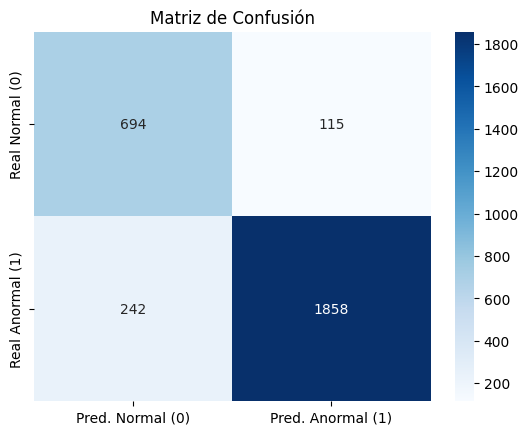

In [ ]:
# Mapa de calor como la matriz de confusión, con los valores dentro de las
  # celdas, números enteros, color azul, y etiquetas de ejes x e y:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred. Normal (0)', 'Pred. Anormal (1)'],
            yticklabels=['Real Normal (0)', 'Real Anormal (1)'])

plt.title('Matriz de Confusión') # Título.
plt.show() # Mostrar figura.

De los resultados se puede observar un alto desempeño global, pues el modelo alcanza un accuracy de 0.88, lo que significa que acierta el 88% de los latidos. La AUC de 0.94 indica una excelente capacidad de discriminación entre las dos clases en todos los umbrales posibles. El modelo detecta el 88% de las arritmias reales con una precisión del 94% y recupera correctamente el 86% de los latidos sanos. Se observa también que la mayoría de los errores fueron falsos negativos (242), pues había algunas gráficas que eran muy parecidas entre sí.

Dados los resultados obtenidos, el modelo TDA obtuvo un buen desempeño, aunque es posible realizar mejoras, optimizaciones posibles, como los parámetros del slidind window embedding tomando rangos superiores de búsqueda para tau y dim, tomar en cuenta los n-agujeros en el diagrama de persistencia (n>1), probar esquemas de vectorización alternativos como imágenes de persistencia, buscar unos mejores hiperparámetros del bosque aleatorio, probar con otro algoritmo de aprendizaje automático, o incluso
con redes neuronales (CNN pueden explotar la estructura espacial de las vectorizaciones, para aprender filtros locales como picos y patrones topológicos), entre otras sugerencias.